In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [20]:
# Data augmentation with balanced and meaningful transformations for medical images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Minimal rotations
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],  # Minimal brightness adjustments
    zoom_range=0.1,
    horizontal_flip=True,  # Allow horizontal flips (common in medical imaging)
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [21]:
# Train and test generators
train_generator = train_datagen.flow_from_directory(
    'chest_xray/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for ROC and AUC calculations
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
# Load Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = True  # Unfreeze all layers for fine-tuning


In [23]:
# Unfreeze only the last 10 layers for fine-tuning
for layer in base_model.layers[:-10]:  
    layer.trainable = False

In [24]:
# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # L2 regularization
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [25]:
# Compile the model with a very low learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
# Address class imbalance by calculating class weights
class_weights = {0: len(train_generator.classes) / (2 * sum(train_generator.classes == 0)),
                 1: len(train_generator.classes) / (2 * sum(train_generator.classes == 1))}

In [27]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_xception_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [28]:
# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.8835 - loss: 11.5846 - val_accuracy: 0.8718 - val_loss: 6.0295 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 163s 988ms/step - accuracy: 0.9494 - loss: 4.6909 - val_accuracy: 0.9231 - val_loss: 2.4064 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 995ms/step - accuracy: 0.9571 - loss: 1.8717 - val_accuracy: 0.9151 - val_loss: 1.0528 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.9598 - loss: 0.7908 - val_accuracy: 0.9167 - val_loss: 0.5628 - learning_rate: 1.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9647 - loss: 0.3632 - val_accuracy: 0.9167 - val_loss: 0.4302 - learning_rate: 1.0000e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9641 - loss: 0.2188 - val_accuracy: 0.9183 - val_loss: 0.2822 - learning_rate: 1.0000e-04
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/ste

In [35]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 800ms/step - accuracy: 0.9088 - loss: 0.2376
Test Loss: 0.2132, Test Accuracy: 0.9231


In [36]:
# Predictions for evaluation metrics
y_pred = model.predict(test_generator).ravel()
y_pred_class = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 670ms/step


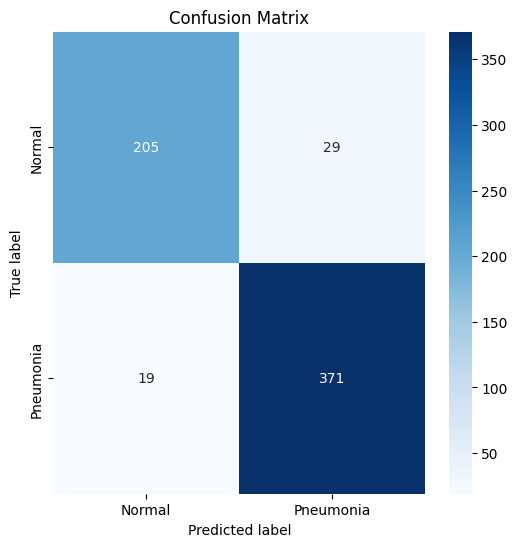

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Classification Report
print(classification_report(y_true, y_pred_class))


              precision    recall  f1-score   support

           0       0.92      0.88      0.90       234
           1       0.93      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



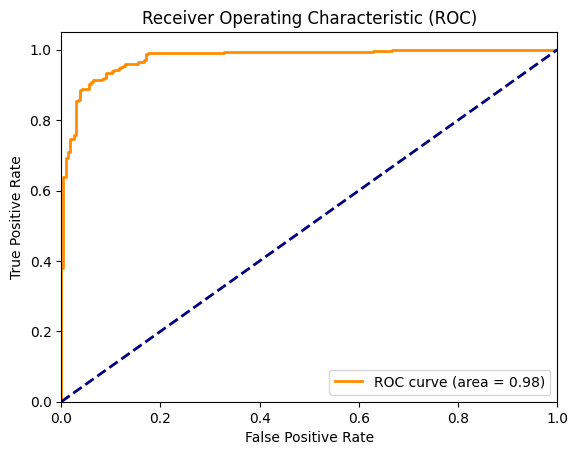

In [40]:
# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [34]:
# # Additional metrics: Precision, Recall, F1-score
# from sklearn.metrics import precision_score, recall_score, f1_score

# precision = precision_score(y_true, y_pred_class)
# recall = recall_score(y_true, y_pred_class)
# f1 = f1_score(y_true, y_pred_class)

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

# Load the Saved Model

In [45]:
# Define the test data generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'chest_xray/test',
    target_size=(150, 150),  # Match the input size of the trained model
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Ensure predictions align with ground truth
)

Found 624 images belonging to 2 classes.


In [46]:
# Recreate the model architecture
base_model = Xception(weights=None, include_top=False, input_shape=(150, 150, 3))

In [47]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [48]:
# Build the model by providing an input shape
model.build(input_shape=(None, 150, 150, 3))

In [49]:
# Load the saved weights
model.load_weights('best_xception_model.keras')

In [50]:
# Compile the model (required for evaluation)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [51]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9088 - loss: 0.2376
Test Loss: 0.2132, Test Accuracy: 0.9231


In [52]:
# Generate predictions for evaluation
y_pred = model.predict(test_generator).ravel()
y_pred_class = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step


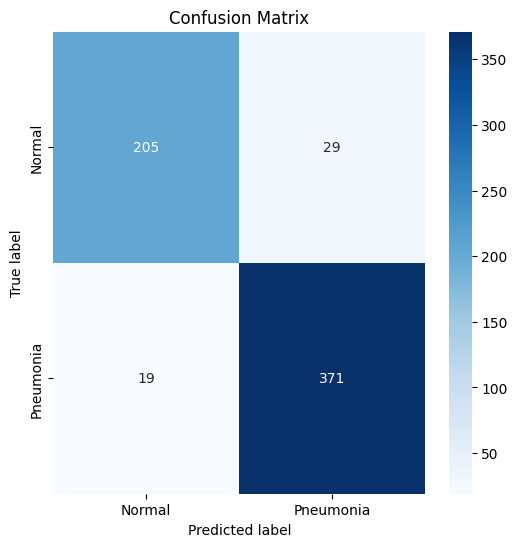

In [53]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [54]:
# Classification Report
print(classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       234
           1       0.93      0.95      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



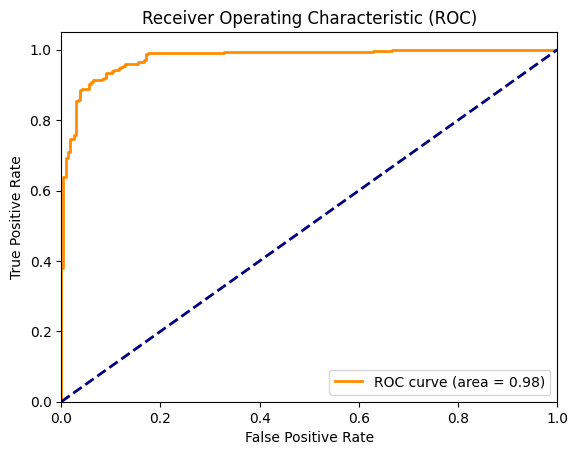

In [55]:
# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [58]:
# AUC Score
auc = roc_auc_score(y_true, model.predict(test_generator).ravel())
print(f'AUC Score: {auc:.4f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
AUC Score: 0.9765
